In [1]:
import os
import pandas as pd
import datetime

import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import importlib


from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import callbacks  

# project specific
from utils import data_handler
from utils.models import LSTM



import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go

# for translation of gene symbols
import mygene

import pathlib
from tensorflow import keras
import scipy

from sklearn.preprocessing import normalize


from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras

from utils import feature_selection

# datasets

# default path of the folder containing the salmon files
absolute_path = '/Users/aygalic/Thesis/data/quant/'  
metadata_path = '/Users/aygalic/Thesis/METADATA_200123.xlsx'  


mg = mygene.MyGeneInfo()

In [2]:
# from filename to tensor
# here we open a single file passed as "filename" we return a tensor of TPM values.
def load_patient_data(filename, path = absolute_path):
  #specify read types for our data
  read_types = [float()]
  # get a first sample to base everything of
  text = pathlib.Path(os.path.join(path,filename)).read_text()
  lines = text.split('\n')[1:-1]
  # the 3rd column correspond to TPM values.
  features = tf.io.decode_csv(lines, record_defaults=read_types, field_delim = "\t", select_cols=[3])
  data = tf.convert_to_tensor(features)[0]
  return data

In [3]:
# here we open a single file passed as "filename" we return a lit of the values names.
def get_names(filename, path = absolute_path):
    names = pd.read_csv(os.path.join(path,filename), sep='\t')
    return [n.split(".")[0] for n in names.Name]

In [4]:
### now we design a function that return a dataset of multivriate time series or the individual timestamps

def generate_dataset(path = absolute_path, 
                     metadata_path = metadata_path,
                     feature_selection_threshold = None, 
                     batch_size = 64, 
                     subsample = None, 
                     return_id = False,
                     retain_phases = None,
                     feature_selection_proceedure = None,
                     sgdc_params = None,
                     class_balancing = None,
                     normalization = True,
                     minimum_time_point = "V08",
                     as_time_series = True,
                     transpose = False,
                     dataset_of_interest = "genes",
                     MT_removal = True,
                     log1p = True):

    if(dataset_of_interest not in ["genes", "transcripts"]):
        print("err, 'dataset_of_interest' must be either 'genes' or 'transcripts'")
        return
    # getting entries ready
    # each couple of entries correspond to one patient, we are only interested in the "transcript" files
    entries = os.listdir(path)
    #entries_transcripts = [e for e in entries if "transcripts" in e ]
    entries = [e for e in entries if dataset_of_interest in e ]
    
    # we load metadata, so we can have access to additional information not included in the filename
    meta_data = pd.read_excel(metadata_path, header = 1, usecols = range(1,10) )

    ###########################################
    ###### pre-loading patient selection ######
    ###########################################
    # selecting which entires to include in our analysis

    # To avoid the natural tendency of the model to base its response to different phases
    # we provide the option to focus our analysis on either or both phases of the study.
    

    if(retain_phases == "1"):
        entries = [e for e in entries if "Phase1" in e ]
        print("retained phase 1")
    elif(retain_phases == "2"):
        entries = [e for e in entries if "Phase2" in e ]
        print("retained phase 2")
    elif(retain_phases == "Both"):
        print("Retaining patients that are included in phases 1 & 2")
        phase_1_ids = [p.split(".")[1] for p in  entries if "Phase1" in p]
        phase_2_ids = [p.split(".")[1] for p in  entries if "Phase2" in p]
        # Find the entries that match with both Phase 1 and Phase 2
        common_ids = set(phase_1_ids) & set(phase_2_ids) # set intersection
        entries_matching_both_phases = [entry for entry in entries if any(f".{common_id}." in entry for common_id in common_ids)]
        entries = entries_matching_both_phases
    elif(retain_phases == None):
        print("not applying any filtering over phases")
    else:
        print("Warning: 'retain_phases' argment wrong.") # couldn't use warning due to conflicts


    # if we want a smaller dataset for testing purposes
    if(subsample is not None):
        entries = entries[0:subsample]

    # We can decide to only include patient who completed a given quantities of timepoints
    # The following stategy for filtering also filters out every patient who have missed a visit up to the given timepoint.
    # This comportement could be tweaked easely later on
    # a bit clunky though
    if(minimum_time_point == "BL"):
        print("retaining all patient who have at least passed the Base Line Visit...")
        BL_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "BL"] 
        matchin_entries = [entry for entry in entries if entry.split(".")[1] in BL_ids]
        entries = matchin_entries
    elif(minimum_time_point == "V02"):
        print("retaining all patient who have at least passed the Base Line to month 6 Visit...")
        BL_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "BL"] 
        V02_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "V02"] 
        common_ids = set(BL_ids) & set(V02_ids) 
        matchin_entries = [entry for entry in entries if entry.split(".")[1] in common_ids]
        entries = matchin_entries
    elif(minimum_time_point == "V04"):
        print("retaining all patient who have at least passed the Base Line to month 12 Visit...")
        BL_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "BL"] 
        V02_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "V02"] 
        V04_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "V04"] 
        common_ids = set(BL_ids) & set(V02_ids) & set(V04_ids) 
        matchin_entries = [entry for entry in entries if entry.split(".")[1] in common_ids]
        entries = matchin_entries
    elif(minimum_time_point == "V06"):
        print("retaining all patient who have at least passed the Base Line to month 24 Visit...")
        BL_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "BL"] 
        V02_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "V02"] 
        V04_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "V04"] 
        V06_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "V06"] 
        common_ids = set(BL_ids) & set(V02_ids) & set(V04_ids) & set(V06_ids) 
        matchin_entries = [entry for entry in entries if entry.split(".")[1] in common_ids]
        entries = matchin_entries
    
    # if we want time series, we constrain them to only patients that went through every visits.
    elif(minimum_time_point == "V08" or as_time_series == True):
        print("retaining all patient who have passed all visits...")
        BL_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "BL"] 
        V02_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "V02"] 
        V04_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "V04"] 
        V06_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "V06"] 
        V08_ids = [p.split(".")[1] for p in  entries if p.split(".")[2] == "V08"] 
        common_ids = set(BL_ids) & set(V02_ids) & set(V04_ids) & set(V06_ids) & set(V08_ids) 
        matchin_entries = [entry for entry in entries if entry.split(".")[1] in common_ids]
        entries = matchin_entries




    # sanity check : are the patient numbers actually numeric ? 
    entries = [e for e in entries if e.split(".")[1].isnumeric() ]

    # sanity check : don't load patient where some values are missing
    Na_s =  meta_data[meta_data.isna().any(axis=1)]["Patient Number"]
    entries = [e for e in entries if e.split(".")[1] not in str(Na_s) ]

    ###########################################
    ############ loading patients  ############
    ###########################################

    # load the dataset into an array 
    print("loading samples...")
    data = [load_patient_data(e, path) for e in entries]

    # get the entry name list
    names = get_names(entries[0])
    
    # remove artifacts by keeping samples of correct length
    if(dataset_of_interest == "transcprits"):
        samples_to_keep = [1 if s.shape == (95309) else 0 for s in data]
    elif(dataset_of_interest == "genes"):
        samples_to_keep = [1 if s.shape == (34569) else 0 for s in data]
        
    print("loaded",len(samples_to_keep), "samples")
    
    train_ds = [sample for (sample, test) in  zip(data, samples_to_keep) if test]
    data_array = np.array(train_ds)

    patient_id = [int(p.split(".")[1]) for (p, test) in  zip(entries, samples_to_keep) if test]

    # only keep metadata for selected patients
    meta_data = meta_data.set_index('Patient Number')
    meta_data = meta_data.reindex(index=patient_id)
    meta_data = meta_data.reset_index()





    ###########################################
    ############ feature selection  ###########
    ###########################################
    
    print("retriving symbols for genes")
    entry = entries[0] # we pick an entry to get the names from
    symbols = mg.getgenes(get_names(entry), fields='symbol', species='human',verbose = 0) # takes around 90 sec
    query_result = [s["symbol"] if "symbol" in s else s["query"] for s in symbols]
    names = query_result
    
    if(MT_removal == True):
        is_not_MT = [False if q.startswith('MT') else True for q in query_result]
        print("removing", len(is_not_MT) - sum(is_not_MT), "mithocondrial genes from the dataset")
        data_array = data_array[:,is_not_MT]
        names = [name for (name, test) in  zip(names, is_not_MT) if test]


    # if feature selection is applied
    if(feature_selection_threshold is not None):
        print("selecting genes based on median absolute deviation threshold: ",feature_selection_threshold, "...")
        gene_selected = feature_selection.MAD_selection(data_array, feature_selection_threshold)
        data_array = data_array[:,gene_selected]
        names = [name for (name, test) in  zip(names, gene_selected) if test]

    if(feature_selection_proceedure == "LASSO"):
        # for each patient in our dataset, we want to know to what cohort he belongs
        cohorts = np.array(meta_data["Cohort"], dtype=np.int32)
        print("selecting genes based on LASSO-like classification...")
        gene_selected = feature_selection.LASSO_selection(data_array, cohorts, sgdc_params, class_balancing)
        data_array = data_array[:,gene_selected]
        names = [name for (name, test) in  zip(names, gene_selected) if test]



    print("number of genes selected : ", len(data_array[0]))


    ###########################################
    ############## normalisation  #############
    ###########################################

    if(normalization == True): 
        print("normalizing data...")
        data_array = normalize(data_array)
        print("normalization done")

    if(log1p == True): 
        data_array = np.log1p(data_array)



    ##########################################
    ######## Building the time series ########
    ##########################################
    print("number of seq in the dataset :", len(data_array))

    if(as_time_series == True):
        print("converting samples to time series")
        big_bad_dict = {key: [sample for (sample, name) in zip(data_array, entries) if int(name.split(".")[1]) == key] for key in patient_id}

        print("number of actual individual to be studied :", len(big_bad_dict))

        # Convert dictionary values to numpy arrays
        sequences = np.array(list(big_bad_dict.values()), dtype=np.float32)

        # Step 2: Create a TensorFlow Dataset
        x_train = tf.data.Dataset.from_tensor_slices(sequences)

        if(transpose):
            print("using transposed data...")

            # Define a function to transpose a sequence
            def transpose_sequence(sequence):
                return tf.transpose(sequence, perm=[1, 0])

            # Transpose each element in the dataset
            x_train = x_train.map(transpose_sequence)


        # to keep track of which timeserie correspond to which identifier
        sequence_names = list(big_bad_dict.keys())
    else:
        # we don't assemble the files into timeseries and simply return the TPM values and the corresponding filename
        print("keeping sample as is, no conversion to time series")
        x_train = tf.data.Dataset.from_tensor_slices(data_array)
        sequence_names = [f for (f, test) in  zip(entries, samples_to_keep) if test]

    # make it a batched dataset
    dataset = x_train.batch(batch_size)
    #dataset = x_train # trying without batching the dataset
    if(return_id):
        return dataset, sequence_names, len(data_array[0]), names
    return dataset, len(data_array[0]), names








In [6]:
as_time_series = True

sgdc_params = {
            #'penalty':["elasticnet", "l1", "l2"],
            'penalty':["l1"],
            #'l1_ratio':np.linspace(0.1, 1, 5),
            'alpha':np.linspace(0.1, 0.5, 5),
        }


dataset, index_names, n_genes, gene_names = generate_dataset(feature_selection_threshold = None, 
                                                            #feature_selection_threshold = 2, 
                                                            batch_size = 32, 
                                                            subsample = None, 
                                                            return_id = True,
                                                            retain_phases = "Both",
                                                            feature_selection_proceedure = None,
                                                            sgdc_params = None,
                                                            class_balancing = None,
                                                            normalization = False,
                                                            minimum_time_point = "V08",
                                                            as_time_series = as_time_series,
                                                            transpose = False,
                                                            dataset_of_interest = "genes",
                                                            #MT_removal = False,
                                                            MT_removal = True,
                                                            log1p = True)

Retaining patients that are included in phases 1 & 2
retaining all patient who have passed all visits...
loading samples...



get the dataset as a numpy object for data manipulation

In [ ]:
# get everything out of TensorFlow back to numpy/pandas
data = np.concatenate(list(dataset.as_numpy_iterator()), axis=0)


if(as_time_series):
    data = data.reshape(data.shape[0]*data.shape[1], -1)
    data = pd.DataFrame(data)
    data.columns = gene_names
    data.index = np.repeat(index_names, 5, axis=0)
else:
    data = pd.DataFrame(data)
    data.columns = gene_names
    data.index = filenames


In [ ]:
print(data.head())

          TOP1  IFIT1P1  HMGB3P7  ENSG00000196331  ENSG00000206044  DEFB109B   
3442  4.929780      0.0      0.0         0.835562              0.0       0.0  \
3442  4.928080      0.0      0.0         0.515907              0.0       0.0   
3442  6.532544      0.0      0.0         1.823079              0.0       0.0   
3442  5.860621      0.0      0.0         0.879249              0.0       0.0   
3442  5.041882      0.0      0.0         0.000000              0.0       0.0   

      ENSG00000206028     FMNL2  METTL24       VCY  ...   DEFB119    FAM8A1   
3442         0.000000  0.218794      0.0  0.000000  ...  0.980756  0.455257  \
3442         0.000000  0.134056      0.0  0.000000  ...  0.905485  0.654461   
3442         1.554090  0.000000      0.0  2.073865  ...  2.158516  1.847376   
3442         0.104765  0.250679      0.0  0.000000  ...  1.053099  0.953953   
3442         0.000000  0.223474      0.0  0.000000  ...  0.595103  0.476525   

         UBBP4  C17orf58   MIR4755     GCNT1

# Exemple pipeline with scprep

In [ ]:
import scprep


In [ ]:
# Remove empty columns and rows
data = scprep.filter.remove_empty_cells(data)
data = scprep.filter.remove_empty_genes(data)

/Users/aygalic/.local/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Axes: xlabel='Library size', ylabel='Number of cells'>

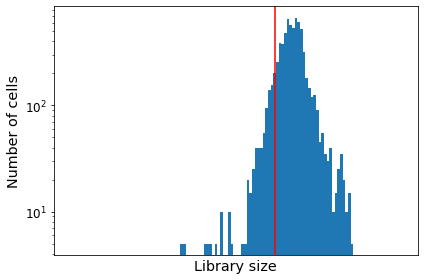

In [ ]:
# Filter by library size to remove background
scprep.plot.plot_library_size(data, cutoff=50000)

In [ ]:
data = scprep.filter.filter_library_size(data, cutoff=50000)

In [14]:
# not enough RAM to run

# Filter by mitochondrial expression to remove dead cells
#mt_genes = scprep.select.get_gene_set(data, starts_with="MT")
#scprep.plot.plot_gene_set_expression(data, genes=mt_genes, percentile=90)


#data = scprep.filter.filter_gene_set_expression(data, genes=mt_genes, percentile=90)


: 

: 

In [ ]:
# Library size normalize
data_norm = scprep.normalize.library_size_normalize(data)
# Square root transform
data_sqrt = scprep.transform.sqrt(data_norm)

# Viz Viz


In [20]:
log_plus_one_df = np.log1p(df)

In [19]:
fig1 = go.Figure(go.Heatmap(z=log_plus_one_df, colorscale='viridis'))


In [23]:
fig1.write_html("../img/log_plus_one.html")


In [27]:
import seaborn as sns

In [35]:
#!pip install fastcluster # that thing made it actually slower
#!pip uninstall fastcluster 


Found existing installation: fastcluster 1.2.6
Uninstalling fastcluster-1.2.6:
  Would remove:
    /opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/_fastcluster.cpython-39-darwin.so
    /opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/fastcluster-1.2.6.dist-info/*
    /opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/fastcluster.py
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user
zsh:1: command not found: Y


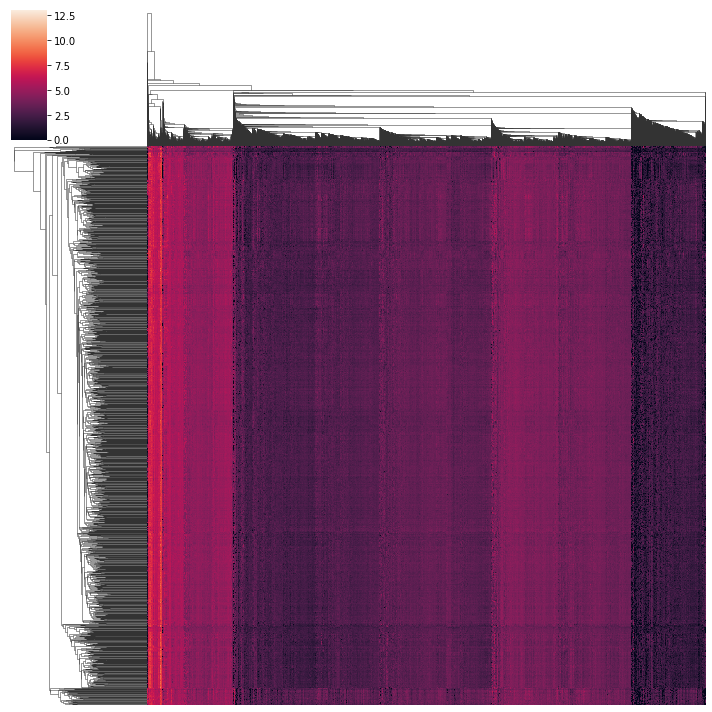

In [49]:
#cluster_plot = sns.clustermap(log_plus_one_df,yticklabels=False,xticklabels=False)
cluster_plot = sns.clustermap(log_plus_one_df,yticklabels=False,xticklabels=False)
cluster_plot

In [50]:
fig = cluster_plot.fig
fig.savefig("../img/seaborn_plot.jpg", dpi=300)